# A linear approximation of Rayleigh-Brillouin scattering spectra

This notebook demonstrates the code from the publication:


....

Rayleigh-Brillouin scattering is the basis of many remote sensing techniques, including high spectral resolution lidar measurements of aerosols and wind. Rayleigh-Brillouin spectra can be accurately estimated using models like the so-called Tenti's S6 and Pan's S7 models. Unfortunately, these are computationally expensive and can be the bottleneck for real-time lidar processing and iterative parameter estimation problems. This short article describes a very
efficient linear approximation of the Rayleigh-Brillouin spectra based on Principal Component Analysis (PCA). Using PCA, the outputs of the above models can be approximated with very high accuracy using a single matrix
multiplication. The described method can be applied to the output of any detailed scattering model, so it can be used for a wide range of problems, e.g. for scattering from different gases (Air, N$_2$, O$_2$, ...) and for different ranges of temperature and pressure. The precision of the approximation can be tuned to the requirements of the studied problem, and can easily exceed the actual accuracy of the reference models.

### Methodology

The basic steps of the method are:
1. Use Tenti S6 model to create a large number of reference distributions, for a large range of parameters T, P.
2. Use a PCA algorithm to describe these distributions as a linear combination of few (e.g. 5) basis components.
3. Use a polynomial approximation to approximate how each weighting factor changes with y.
4. Given the polynomials and components, a RS distribution can be calculated for any y.

The last step can be described by a linear system, so a large number of distributions can be calculated at once, given an appropriate vector $\mathbf{y}$

### Code walk-through

In [1]:
# Import code
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt  # For plotting
from itertools import cycle
from cycler import cycler

from pca_approximation import pca_approximation, helper_functions; reload(pca_approximation)

<module 'pca_approximation.pca_approximation' from '/media/ioannis/d02075ee-5754-41f7-bcfd-694362e1806d/Work/Programming/modules/pca_rb_scattering/pca_approximation/pca_approximation.pyc'>

In [2]:
# Define global styles for the plots
plt.style.use('classic')

plt.rc('axes', prop_cycle=(cycler('color', ['#377eb8', '#e41a1c','#4daf4a',]) +
                           cycler('linestyle', ['-', '--', ':'])),
               labelsize=8)
plt.rc('lines', lw=2)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)


%matplotlib inline

In [3]:
single_column_figure = (3.31, 2.07)  # width 8.4cm
double_length_figure = (3.31, 3.31)
onehalf_column_figure = (5.51, 3.42)
double_column_figure = (4.7, 3.42)

mpl.rc('figure', figsize=(5, 3.15), dpi=300)
mpl.rc('font', size=8)
mpl.rc('legend', fontsize=7)
mpl.rc('axes.formatter', limits=(-3, 3))

#### Read a reference dataset
We read a reference dataset stored in the text file. We also specify the number of PCA components to use, and the order of polynomials we use to fit. 

In [4]:
# Choose the decomposition parameters
pca_component_number = 4
polynomial_degree = 6
training_subset = 0.7

training_dataset = pca_approximation.TrainingDataset('../data/training_dataset.txt', 
                                                     pca_component_number=pca_component_number, 
                                                     degrees=polynomial_degree,
                                                     training_subset=training_subset)

Training dataset shape: (2500, 500)
Number of xi: (500,)


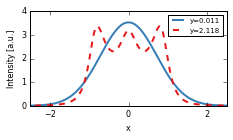

In [5]:
# Explore the results.

print "Training dataset shape:", training_dataset.X.shape
print "Number of xi:", training_dataset.xi.shape
_ = training_dataset.plot_extreme_y_training_profiles(title="", figsize=single_column_figure)
plt.xlim(-2.5, 2.5)
plt.savefig('fig1.pdf')

#### Construct the matrix M

We decompose the reference dataset using PCA algorithm to few basic components. The number of components needed can be defined empirically, but 4-5 should be enough.

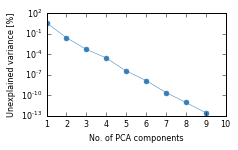

In [6]:
#training_dataset.plot_explained_variance(10, figsize=single_column_figure)
#plt.savefig('explained_variance.pdf')

#print training_dataset.unexplained_variance_percentage(10)
training_dataset.plot_unexplained_variance(10, figsize=single_column_figure)
plt.savefig('fig3.pdf')
plt.draw()

We can see that most of the variance is explained by the first 5 components. 

In [7]:
training_dataset.pca_components.shape

(4, 500)

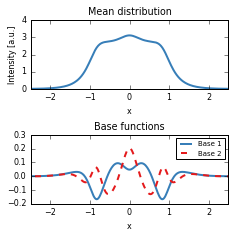

In [8]:
training_dataset.plot_decomposition(2, figsize=double_length_figure )
plt.xlim(-2.5, 2.5)
plt.savefig('fig2.pdf')


The relationship of each column of $W$ and $y$ will be approximated using a polynomial.

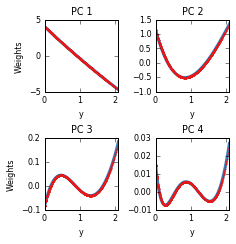

In [9]:
training_dataset.plot_polynomials(fig_width=single_column_figure[0], subplot_height=1.7, axes_per_row=2)
plt.savefig('fig4.pdf')

With these polynomial coefficeints we can now calculate the prediction matrix $M$

In [10]:
print "Reconstruction matrix M shape:", training_dataset.M.shape

Reconstruction matrix M shape: (500, 7)


#### Approximate a distribution for a new y

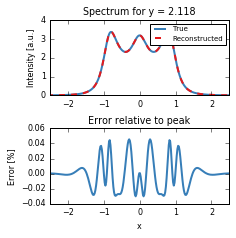

In [11]:
training_dataset.plot_max_error_spectrums(figsize=double_length_figure )
plt.xlim(-2.5, 2.5)
plt.savefig('fig5.pdf')

We can perform the same calculation for many y at once.

In [12]:
y = np.linspace(0, 2, 100)
%timeit training_dataset.reconstruct_spectrum(y)

The slowest run took 46.82 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 189 µs per loop


### Effect of PCA components and polynomial degree 

#### Fixed componenets, variable polynomial degree

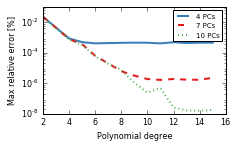

In [13]:
components = [4, 7, 10]
degrees = range(2, 16)

plt.figure(figsize=single_column_figure)
ax = plt.subplot(111)

for component in components:
    max_errors = []
    for degree in degrees:
        training_dataset = pca_approximation.TrainingDataset('../data/training_dataset.txt', 
                                                         pca_component_number=component, 
                                                         degrees=degree, )
        max_error, _, _ = training_dataset.max_error()
        max_errors.append(max_error)

    plt.plot(degrees, max_errors, label="%s PCs" % component)

plt.yscale('log')
ax.get_yaxis().set_major_locator(mpl.ticker.LogLocator(numticks=6))

plt.xlabel('Polynomial degree')
plt.ylabel('Max relative error [%]')
plt.legend()

plt.tight_layout()
plt.savefig('fig6.pdf')

## Refernces

...

Witschas, B. Analytical model for Rayleigh-Brillouin line shapes in air. Appl. Opt. 50, 267-270 (2011).